> **How to run this notebook (command-line)?**
1. Install the `ReinventCommunity` environment:
`conda env create -f environment.yml`
2. Activate the environment:
`conda activate ReinventCommunity`
3. Execute `jupyter`:
`jupyter notebook`
4. Copy the link to a browser


# `Lib-INVENT`: Reinforcement Learning - QSAR model + reaction filter
This example builds on the previous tutorials, demonstrating the usage of a reaction filter. The reaction filter will contain Amide coulping and Buchwald reaction, each of these reactions will be applied to a specific attachment point.

In [1]:
# load dependencies
import os
import re
import json
import tempfile

# --------- change these path variables as required
reinvent_dir = os.path.expanduser("~/Desktop/Reinvent")
reinvent_env = os.path.expanduser("~/miniconda3/envs/reinvent.v3.2")
output_dir = os.path.expanduser("~/Desktop/REINVENT_RL_QSAR_RF_demo")

# --------- do not change
# get the notebook's root path
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

# if required, generate a folder to store the results
try:
    os.mkdir(output_dir)
except FileExistsError:
    pass

## Setting up the configuration
The general setup follows the same pattern as that described in the `Lib-INVENT_RL1_QSAR` tutorial.

### 1. Run Type Block

In [2]:
# initialize the dictionary
configuration = {
    "version": 3,
    "model_type": "lib_invent",
    "run_type": "reinforcement_learning"
}

### 2. Logging Block

In [3]:
# add block to specify whether to run locally or not and
# where to store the results and logging
configuration["logging"] = {
    "sender": "",                          # only relevant if "recipient" is set to "remote"
    "recipient": "local",                  # either to local logging or use a remote REST-interface
    "logging_path": os.path.join(output_dir, "progress.log"), # load this folder in tensorboard
    "result_folder": os.path.join(output_dir, "results"), # output directory for results
    "job_name": "Reinforcement learning QSAR + RF demo",      # set an arbitrary job name for identification
    "job_id": "n/a"                        # only relevant if "recipient" is set to "remote"
}

### 3. Parameters Block

In [4]:
# start assembling the parameters block
configuration["parameters"] = {
    "actor": os.path.join(ipynb_path, "models/library_design.prior"),
    "critic": os.path.join(ipynb_path, "models/library_design.prior"),
    "scaffolds": ["[*:0]N1CCN(CC1)CCCCN[*:1]"],
    "n_steps": 100,
    "learning_rate": 0.0001,
    "batch_size": 128,
    "randomize_scaffolds": False, # important since a RF is to be imposed.

    # configure learning strategy
    "learning_strategy": {
        "name": "dap", 
        "parameters":  {
          "sigma": 120
        }
    }
}

#### Configure the scoring strategy


In [5]:
# configure scoring strategy
scoring_strategy = {
    "name": "lib_invent", # Do not change


    # configure diversity filter. Here we do penalise repetition.
    "diversity_filter":  {
        "name": "NoFilterWithPenalty"    
    }
}

##### Configure Reaction Filter
This example demonstrates how to set up a selective reaction filter.

Smirks for `Amide coupling-Buchwald` reaction. are used and assigned to specific attachment points in the form of a dictionary. The attachment point numbered "1" should follow amide coupling, and attachment point numbered "2" should follow buchwald reaction.
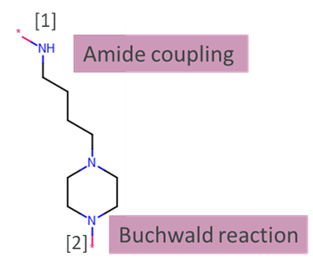

Note that since Python labels from 0, the labels in the dictionary have to be "0" and "1", not "1" and "2".

In [6]:
# configure reaction filter
reaction_filter =  {
    "type":"selective",        
    "reactions": [
        ["[#6;!$(C(C=*)(C=*));!$([#6]~[O,N,S]);$([#6]~[#6]):1][C:2](=[O:3])[N;D2;$(N(C=[O,S]));!$(N~[O,P,S,N]):4][#6;!$(C=*);!$([#6](~[O,N,S])N);$([#6]~[#6]):5]>>[#6:1][C:2](=[O:3])[*].[*][N:4][#6:5]"],
        ["[c;$(c1:[c,n]:[c,n]:[c,n]:[c,n]:[c,n]:1):1]-!@[N;$(NC)&!$(N=*)&!$([N-])&!$(N#*)&!$([ND1])&!$(N[O])&!$(N[C,S]=[S,O,N]),H2&$(Nc1:[c,n]:[c,n]:[c,n]:[c,n]:[c,n]:1):2]>>[*][c;$(c1:[c,n]:[c,n]:[c,n]:[c,n]:[c,n]:1):1].[*][N:2]"]
    ]
}

scoring_strategy["reaction_filter"] = reaction_filter

##### Define the scoring function

In [7]:
scoring_function = {
    "name": "custom_sum",             
    "parallel": False,                  
    "parameters": [
    {
        "component_type": "predictive_property",
        "name": "DRD2",
        "weight": 1,
        "specific_parameters": {
            "model_path": os.path.join(ipynb_path, "models/drd2.pkl"),
            "scikit": "classification",
            "descriptor_type": "ecfp",
            "size": 2048,
            "radius": 3,
            "transformation": {
                "transformation_type": "no_transformation"
            }
        }
    },
    {
        "component_type": "custom_alerts",
        "name": "Custom alerts",              
        "weight": 1,                                             
        "specific_parameters": {
            "smiles": [                          
                "[*;r8]",
                "[*;r9]",
                "[*;r10]",
                "[*;r11]",
                "[*;r12]",
                "[*;r13]",
                "[*;r14]",
                "[*;r15]",
                "[*;r16]",
                "[*;r17]",
                "[#8][#8]",
                "[#6;+]",
                "[#16][#16]",
                "[#7;!n][S;!$(S(=O)=O)]",
                "[#7;!n][#7;!n]",
                "C#C",
                "C(=[O,S])[O,S]",
                "[#7;!n][C;!$(C(=[O,N])[N,O])][#16;!s]",
                "[#7;!n][C;!$(C(=[O,N])[N,O])][#7;!n]",
                "[#7;!n][C;!$(C(=[O,N])[N,O])][#8;!o]",
                "[#8;!o][C;!$(C(=[O,N])[N,O])][#16;!s]",
                "[#8;!o][C;!$(C(=[O,N])[N,O])][#8;!o]",
                "[#16;!s][C;!$(C(=[O,N])[N,O])][#16;!s]"
            ]
        }      
    }]
}

scoring_strategy["scoring_function"] = scoring_function
configuration["parameters"]["scoring_strategy"] = scoring_strategy

### Save the JSON configuration

In [8]:
configuration_JSON_path = os.path.join(output_dir, "RL_QSAR_RF_input.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(configuration, f, indent=4, sort_keys=True)

The resulting configruation file should be placed in the `output_dir` path you specified in the beginning of this notebook.

# Run
Execute in jupyter notebook

In [9]:
%%capture captured_err_stream --no-stderr

# execute REINVENT from the command-line
!{reinvent_env}/bin/python {reinvent_dir}/input.py {configuration_JSON_path}

In [10]:
# print the output to a file, just to have it for documentation
with open(os.path.join(output_dir, "run.err"), 'w') as file:
    file.write(captured_err_stream.stdout)

Execute in command line
```
# activate envionment
$ conda activate reinvent.v3.2

# execute in command line
$ python <reinvent_dir>/input.py <configuration_JSON_path>
```

## Analyse the results
In order to analyze the run in a more intuitive way, we can use `tensorboard`, as described in the `Lib-INVENT_RL1_QSAR` tutorial.

```
# go to the root folder of the output
$ cd <output_dir>

# activate the environment
$ conda activate reinvent.v3.0

# start tensorboard
$ tensorboard --logdir "progress.log"
```

Below is an example output of the run. In contrast with the previous example, the reaction filters now do not follow the validity line. Instead, they demonstrate how the model learns to follow the imposed reaction filters. Since the RFs are chemically reasonable in this case, the model manages to produce output according to them. If instead the user enforced filters which are not compatible with the compounds, this score would stay low.

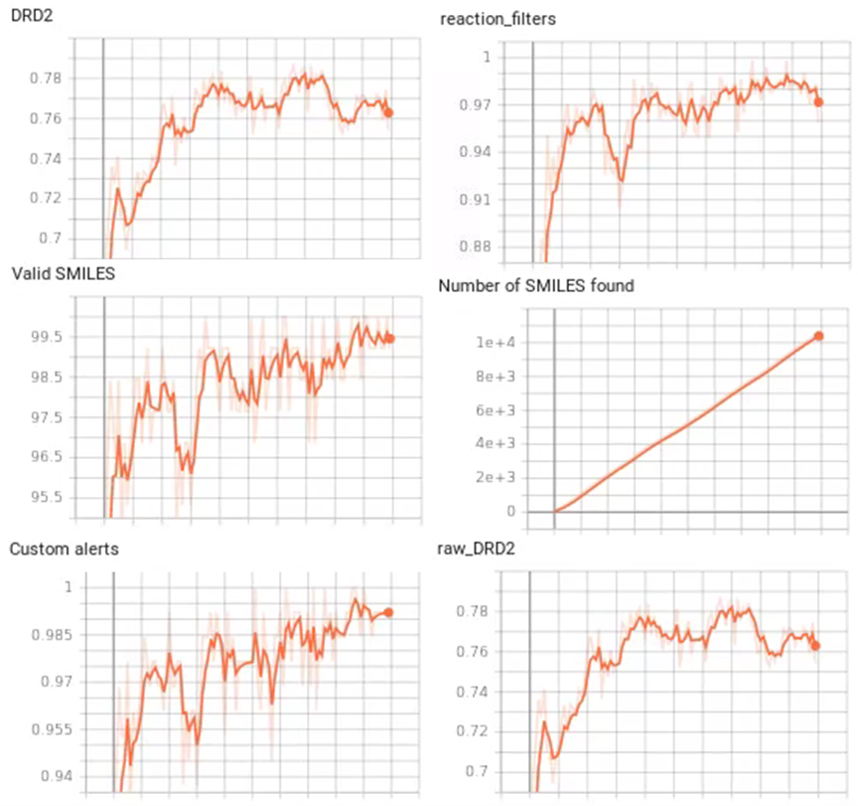